In [1]:
from prismo import PRISMO
import matplotlib.pyplot as plt
import numpy as np
from plotnine import *
import pandas as pd

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
models_multi_group = []
models_single_group = []

for i in range(10):
    models_multi_group.append(PRISMO.load(f"models/multi_group_{i}.h5"))
    models_single_group.append(PRISMO.load(f"models/single_group_{i}.h5"))

## Variance of pathway ranks based on R2

In [3]:
df_list = []

for i in range(len(models_single_group)):
    df = pd.DataFrame(
        {
            "pathway" : models_single_group[i].factor_names,
            "model" : str(i),
        }
    )
    df = df[~df["pathway"].str.startswith("Factor")]
    df.set_index("pathway", inplace=True)
    df["x_mg"] = models_multi_group[i].get_r2()["group_xenium"]["rna"]
    df["x_sg"] = models_single_group[i].get_r2()["group_xenium"]["rna"]
    df["c_mg"] = models_multi_group[i].get_r2()["group_chromium"]["rna"]
    df["x_mg_rank"] = df["x_mg"].rank(method="first", ascending=False).astype(int) - 1
    df["x_sg_rank"] = df["x_sg"].rank(method="first", ascending=False).astype(int) - 1
    df["c_mg_rank"] = df["c_mg"].rank(method="first", ascending=False).astype(int) - 1
    df_list.append(df)

df = pd.concat(df_list)

df.reset_index(inplace=True)
df["pathway"] = df["pathway"].str.replace("HALLMARK_", "").str.replace("_", " ").str.title()

df = df.groupby("pathway").agg(
    mean_x_mg=("x_mg", "mean"),
    std_x_mg=("x_mg", "std"),
    mean_x_sg=("x_sg", "mean"),
    std_x_sg=("x_sg", "std"),
    mean_c_mg=("c_mg", "mean"),
    std_c_mg=("c_mg", "std"),
    mean_x_mg_rank=("x_mg_rank", "mean"),
    std_x_mg_rank=("x_mg_rank", "std"),
    mean_x_sg_rank=("x_sg_rank", "mean"),
    std_x_sg_rank=("x_sg_rank", "std"),
    mean_c_mg_rank=("c_mg_rank", "mean"),
    std_c_mg_rank=("c_mg_rank", "std"),
)

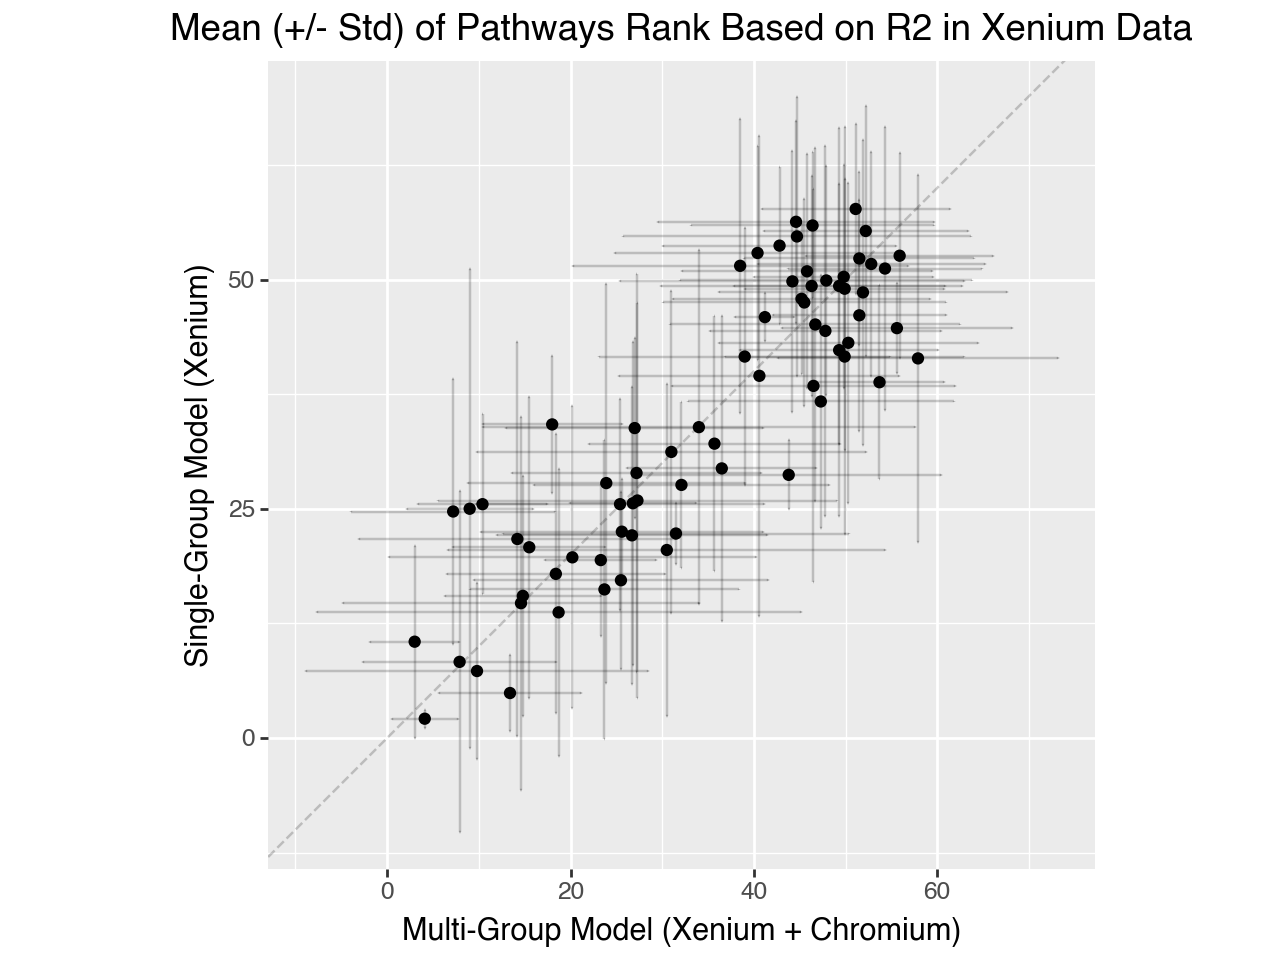

In [4]:
plot = (
    ggplot(df, aes(x="mean_x_mg_rank", y="mean_x_sg_rank"))
    + geom_point()
    + geom_errorbar(aes(ymin="mean_x_sg_rank - std_x_sg_rank", ymax="mean_x_sg_rank + std_x_sg_rank"), width=0.2, alpha=0.2)
    + geom_errorbarh(aes(xmin="mean_x_mg_rank - std_x_mg_rank", xmax="mean_x_mg_rank + std_x_mg_rank"), height=0.2, alpha=0.2)
    + coord_fixed(ratio=1)
    + labs(title="Mean (+/- Std) of Pathways Rank Based on R2 in Xenium Data", x="Multi-Group Model (Xenium + Chromium)", y="Single-Group Model (Xenium)")
    + geom_abline(intercept=0, slope=1, linetype="dashed", alpha=0.2)
)
plot.show()

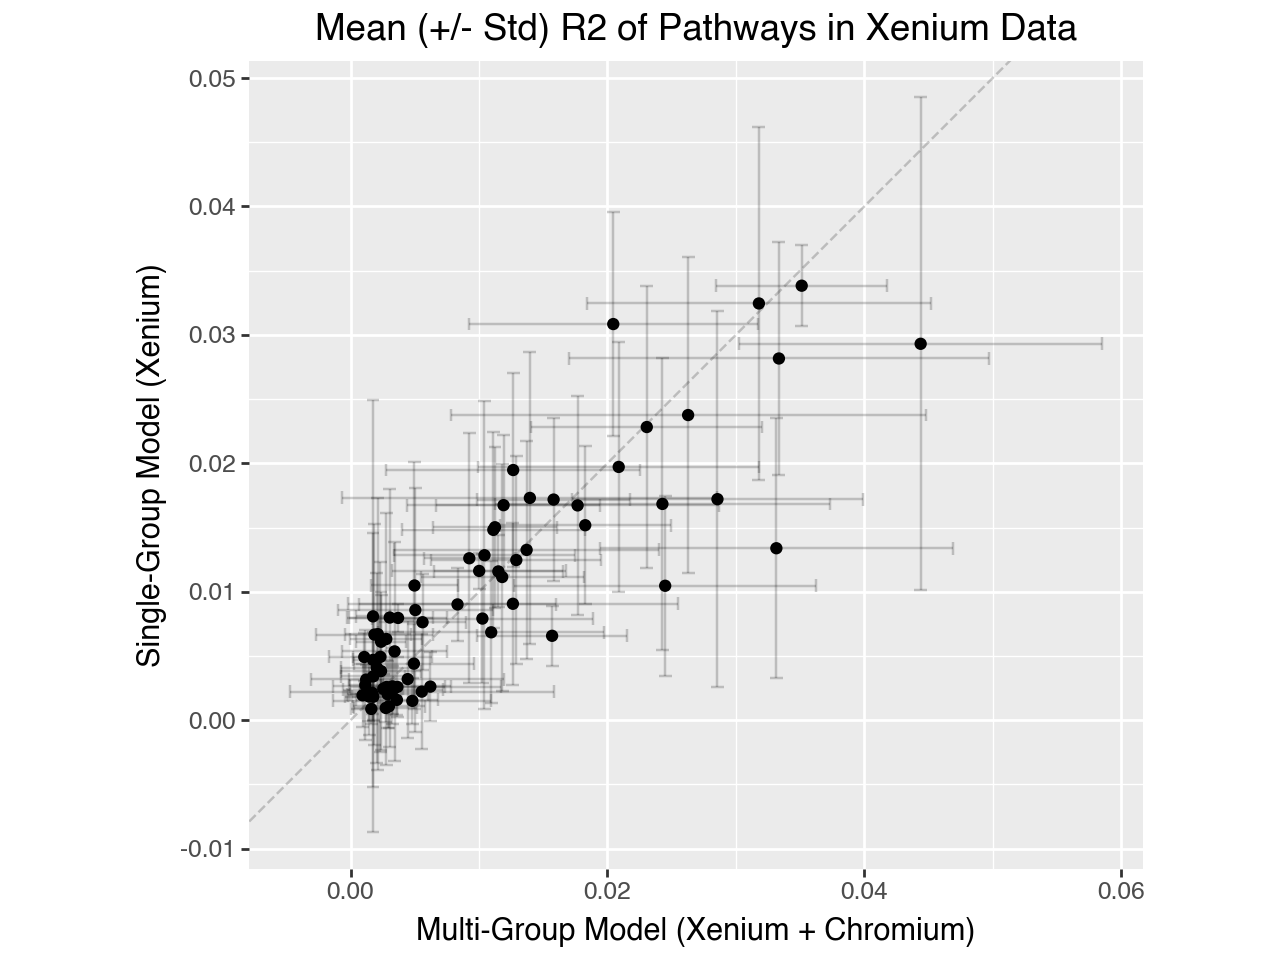

In [5]:
plot = (
    ggplot(df, aes(x="mean_x_mg", y="mean_x_sg"))
    + geom_point()
    + geom_errorbar(aes(ymin="mean_x_sg - std_x_sg", ymax="mean_x_sg + std_x_sg"), width=0.001, alpha=0.2)
    + geom_errorbarh(aes(xmin="mean_x_mg - std_x_mg", xmax="mean_x_mg + std_x_mg"), height=0.001, alpha=0.2)
    + coord_fixed(ratio=1)
    + labs(title="Mean (+/- Std) R2 of Pathways in Xenium Data", x="Multi-Group Model (Xenium + Chromium)", y="Single-Group Model (Xenium)")
    + geom_abline(intercept=0, slope=1, linetype="dashed", alpha=0.2)
)
plot.show()

## Feature order

In [9]:
df_list = []
for seed in range(10):
    df = models_multi_group[seed].get_annotations()["rna"].reset_index(names="factor").melt(id_vars="factor", var_name="feature", value_name="annotation")
    df["weight"] = models_multi_group[seed].get_weights()["rna"].reset_index(names="factor").melt(id_vars="factor", var_name="feature", value_name="weight")["weight"]
    df_list.append(df)

df_mg = pd.concat(df_list)

df_mg = df_mg.groupby(["factor", "feature"]).agg(
    annotation=("annotation", "mean"),
    weight=("weight", "mean"),
    weight_std=("weight", "std"),
)

In [10]:
df_list = []
for seed in range(10):
    df = models_single_group[seed].get_annotations()["rna"].reset_index(names="factor").melt(id_vars="factor", var_name="feature", value_name="annotation")
    df["weight"] = models_single_group[seed].get_weights()["rna"].reset_index(names="factor").melt(id_vars="factor", var_name="feature", value_name="weight")["weight"]
    df_list.append(df)

df_sg = pd.concat(df_list)

df_sg = df_sg.groupby(["factor", "feature"]).agg(
    annotation=("annotation", "mean"),
    weight=("weight", "mean"),
    weight_std=("weight", "std"),
)

In [12]:
df_mg = df_mg[df_mg.index.get_level_values("feature").isin(df_sg.index.get_level_values("feature"))]
df = pd.merge(df_mg, df_sg, left_index=True, right_index=True, suffixes=("_mg", "_sg")).reset_index()
df.factor = df.factor.str.replace("REACTOME", "").str.replace("_", " ").str.title()
df["annotation"] = df["annotation_mg"].astype(bool)
df.drop(columns=["annotation_mg", "annotation_sg"], inplace=True)

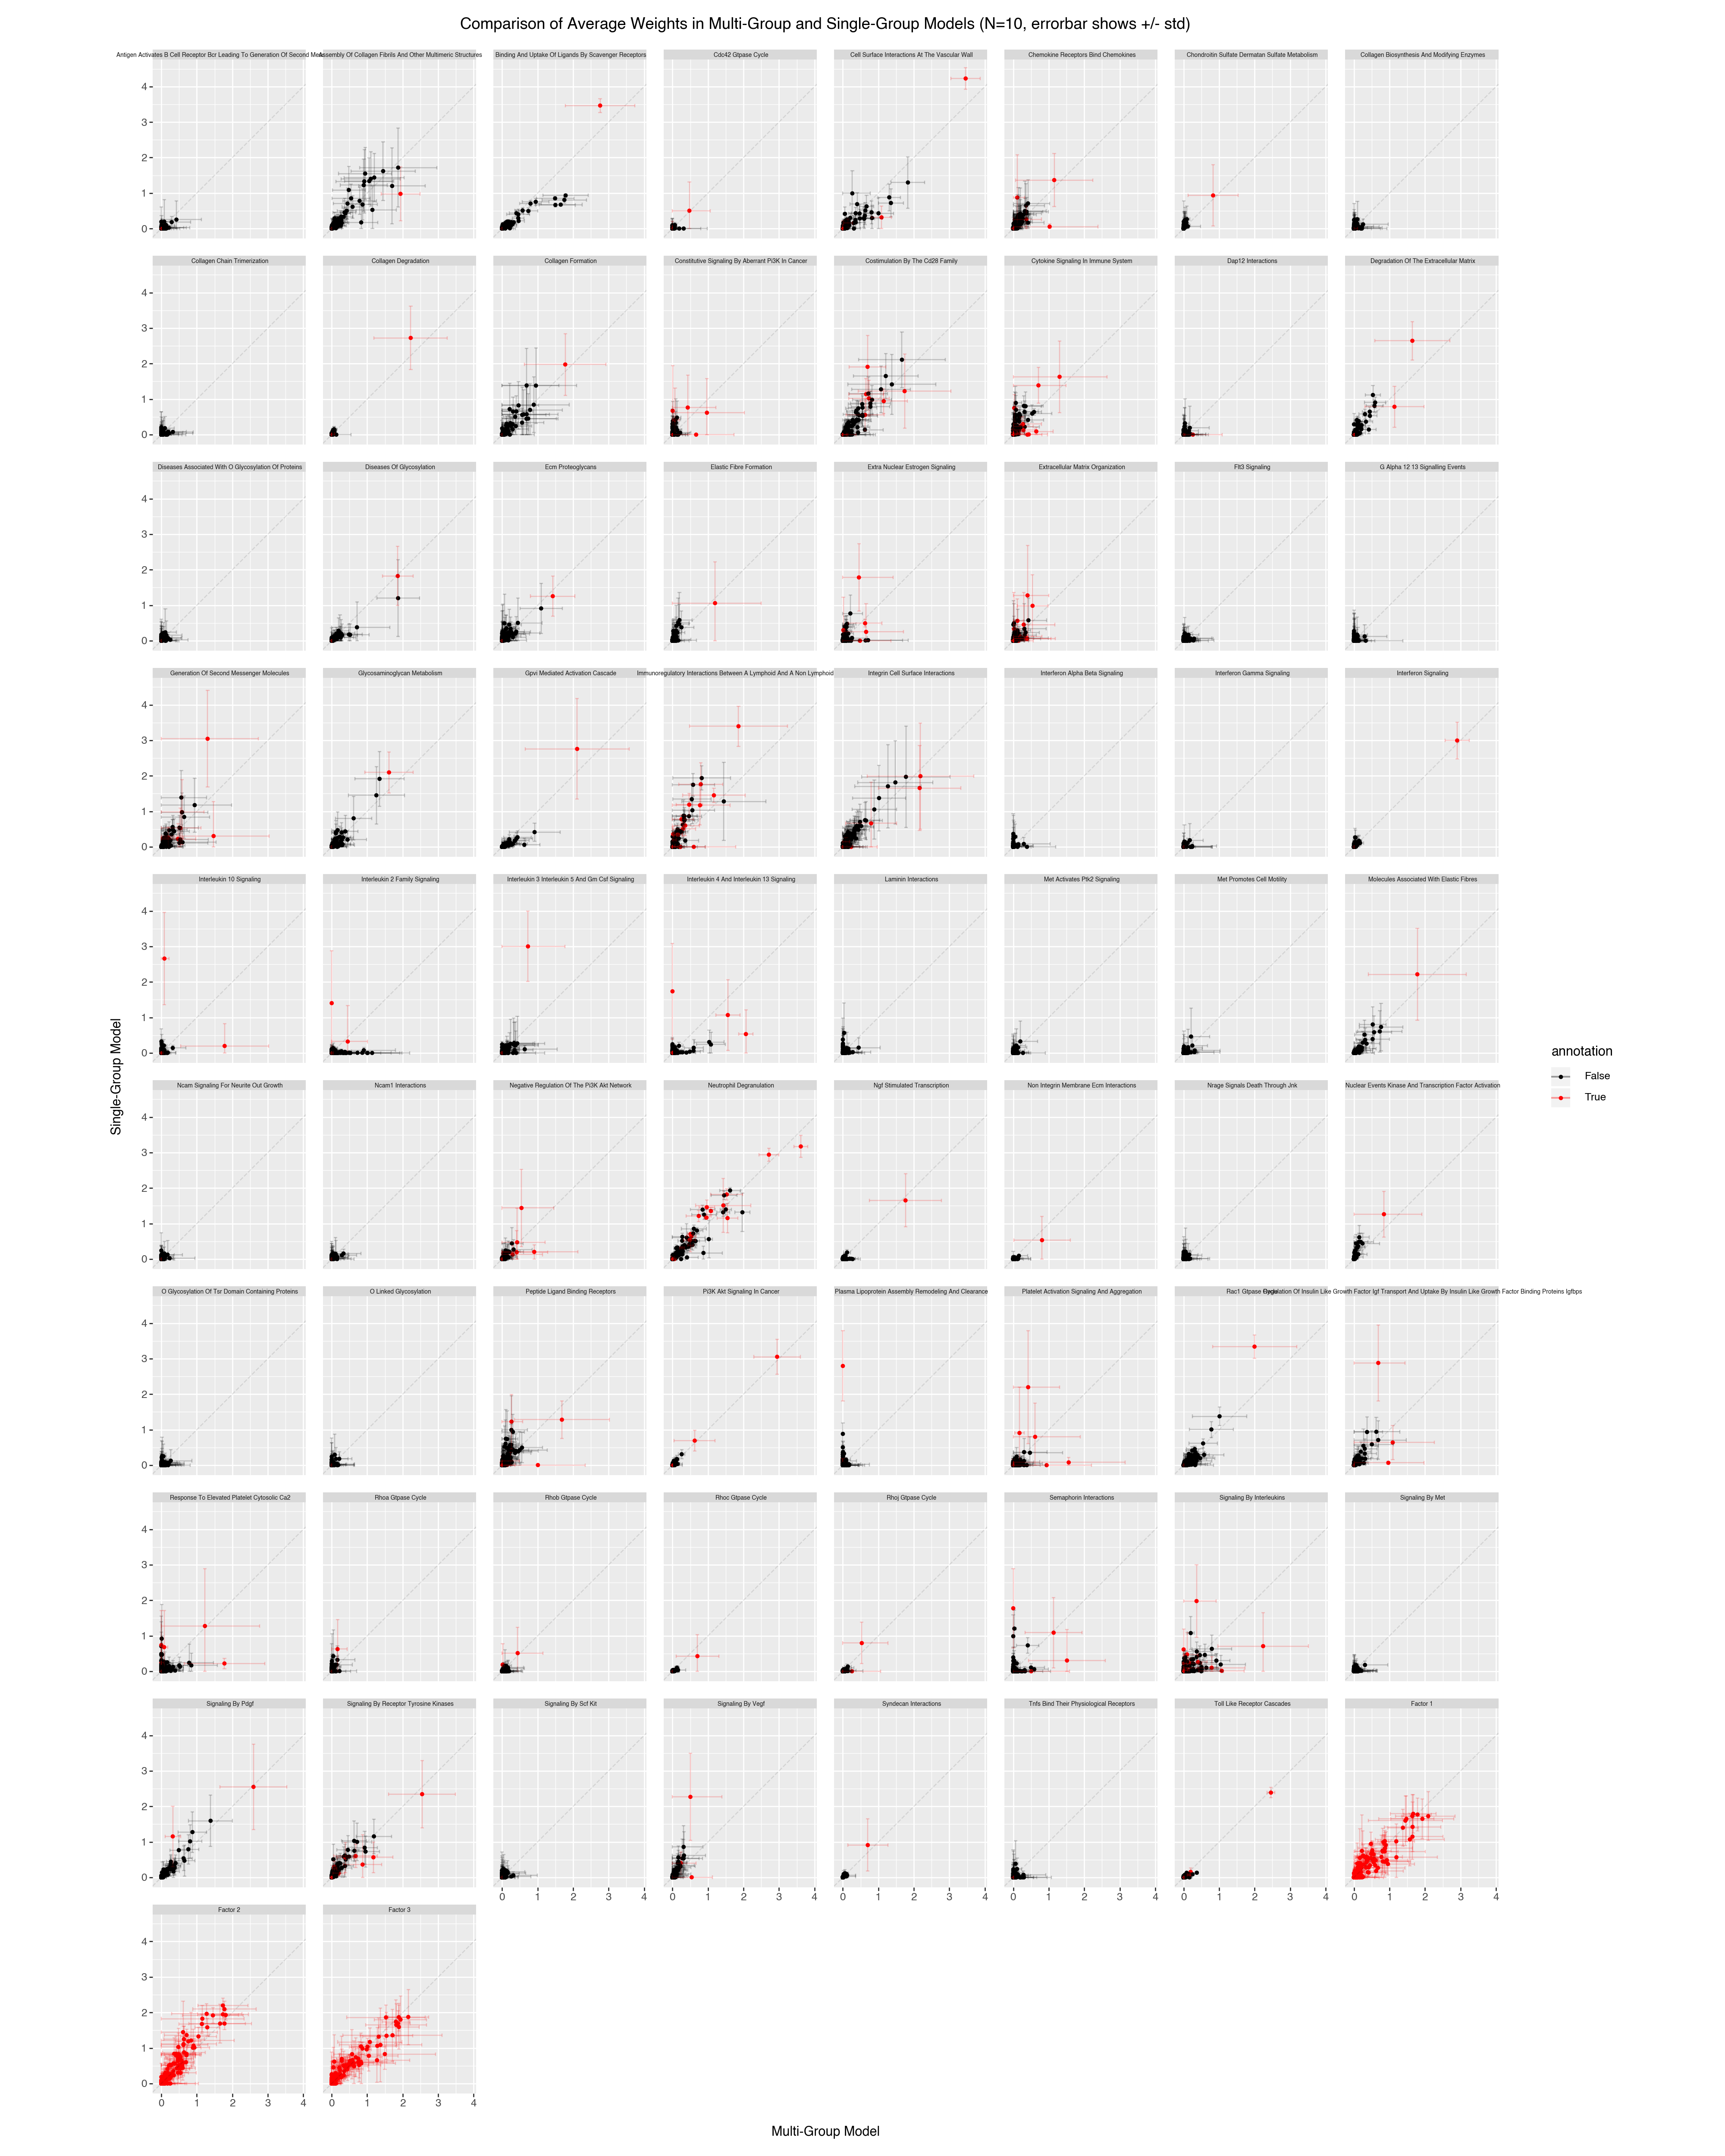

In [19]:
plot = (
    ggplot(df, aes(x="weight_mg", y="weight_sg", color="annotation"))
    + geom_point(size=1.)
    + geom_errorbar(aes(ymin=np.maximum(df["weight_sg"] - df["weight_std_sg"], 0), ymax="weight_sg + weight_std_sg"), width=0.1, alpha=0.2)
    + geom_errorbarh(aes(xmin=np.maximum(df["weight_mg"] - df["weight_std_mg"], 0), xmax="weight_mg + weight_std_mg"), height=0.1, alpha=0.2)
    + facet_wrap("~factor", ncol=8)
    + theme(figure_size=(20, 25), strip_text=element_text(size=5))
    + coord_fixed(ratio=1)
    + geom_abline(intercept=0, slope=1, linetype="dashed", alpha=0.1)
    + scale_color_manual(values=["black", "red"])
    + labs(title="Comparison of Average Weights in Multi-Group and Single-Group Models (N=10, errorbar shows +/- std)", x="Multi-Group Model", y="Single-Group Model")
)
plot.show()
